In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 

plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

colors = {
    'bg': '#EFE8E8',
    'text': '#513838',
    
    'red': '#DC3545',
    'blue': "#0A58CA",
    'cyan': '#0AA2C0',
    'green': '#1AA179',
    'purple': '#7121F3',
    'orange': '#FD7E14',
    'yellow': '#FFC107',
    'pink': '#D63384',
    'white_green': "#64B099"
}

custom_palette = [
    colors['blue'], colors['red'], colors['green'], 
    colors['orange'], colors['purple'], colors['cyan']
]

custom_params = {
    "figure.facecolor": colors['bg'],
    "axes.facecolor": colors['bg'],
    "savefig.facecolor": colors['bg'],
    
    "text.color": colors['text'],
    "axes.labelcolor": colors['text'],
    "xtick.color": colors['text'],
    "ytick.color": colors['text'],
    "font.family": "sans-serif",
    
    "axes.grid": True,
    "grid.color": colors['text'],
    "grid.alpha": 0.15,
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.edgecolor": colors['text'],
    "axes.linewidth": 0.8,
    
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
}

sns.set_theme(
    context="talk",
    style="whitegrid",
    rc=custom_params,
    palette=custom_palette
)

<Figure size 1400x1000 with 0 Axes>

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
df = pd.read_csv('dfc.csv')
neg_df = df[df['review_emotion'] == 0].copy()
neg_df['target_is_tariff'] = neg_df['review_theme'].astype(str).str.lower().str.contains('тарифы и условия').astype(int)
neg_df['influencer_flg'] = neg_df['influencer_flg'].fillna(0).astype(int)
X = neg_df[['influencer_flg']]
X = sm.add_constant(X)
y = neg_df['target_is_tariff']
logit_model = sm.Logit(y, X.astype(float)).fit(disp=0)
print(logit_model.summary())
auc = roc_auc_score(y, logit_model.predict(X.astype(float)))
print(f"ROC AUC: {auc:.4f}")

                           Logit Regression Results                           
Dep. Variable:       target_is_tariff   No. Observations:                18791
Model:                          Logit   Df Residuals:                    18789
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:                0.005476
Time:                        13:22:46   Log-Likelihood:                -7175.6
converged:                       True   LL-Null:                       -7215.2
Covariance Type:            nonrobust   LLR p-value:                 6.146e-19
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.0428      0.027    -75.546      0.000      -2.096      -1.990
influencer_flg     0.4136      0.046      9.027      0.000       0.324       0.503
ROC AUC: 0.5445


In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


df = pd.read_csv('dfc.csv')
negative_reviews = df[df['review_emotion'] == 0].copy()


top_lines_99 = [
    'депозитные продукты', 'кредитные карты', 'инвестиции', 'прочие продукты',
    'автокредит', 'mobile', 'sme','нефинансовые продукты','премиальные сервисы', 'ипотека'
]
top_sources_99 = [
    'banki.ru', 'пульс', 'нет', 'otzovik', 'sravni.ru',
    'пикабу', 'вконтакте', 'суперапп', 'asn'
]

cov_bl = negative_reviews['business_line'].isin(top_lines_99).mean()
cov_src = negative_reviews['review_source'].isin(top_sources_99).mean()

print(f"Покрытие Business Line: {cov_bl:.2%}")
print(f"Покрытие Review Source: {cov_src:.2%}")

negative_reviews['review_theme'] = negative_reviews['review_theme'].astype(str).str.strip()
negative_reviews['target_is_tariff'] = negative_reviews['review_theme'].str.lower().str.contains('тарифы и условия').astype(int)

negative_reviews['business_line_grouped'] = negative_reviews['business_line'].apply(lambda x: x if x in top_lines_99 else 'Other')
negative_reviews['source_grouped'] = negative_reviews['review_source'].apply(lambda x: x if x in top_sources_99 else 'Other')

negative_reviews['is_male'] = (negative_reviews['gender_cd'].fillna('Unknown') == 'M').astype(int)
negative_reviews['influencer_flg'] = negative_reviews['influencer_flg'].fillna(0).astype(int)
negative_reviews['new_flg'] = negative_reviews['new_flg'].fillna(0).astype(int)
negative_reviews['solution_flg'] = negative_reviews['solution_flg'].fillna('Unknown')
# negative_reviews['is_mark_2'] = (negative_reviews['review_mark'].astype(str) == '2').astype(int)

cat_features = ['business_line_grouped', 'source_grouped', 'solution_flg']
num_features = ['is_male', 'influencer_flg', 'new_flg']

model_df = negative_reviews[['target_is_tariff'] + cat_features + num_features].copy()
model_df = pd.get_dummies(model_df, columns=cat_features, drop_first=True)

y = model_df['target_is_tariff']
X = model_df.drop('target_is_tariff', axis=1)
X = sm.add_constant(X)

logit_model = sm.Logit(y, X.astype(float)).fit(method='bfgs', maxiter=1000, disp=0)
print(logit_model.summary())

y_prob = logit_model.predict(X.astype(float))
y_pred = (y_prob > 0.5).astype(int)

print(f"ROC AUC:  {roc_auc_score(y, y_prob):.4f}")
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"F1 Score: {f1_score(y, y_pred):.4f}")

Покрытие Business Line: 91.98%
Покрытие Review Source: 97.87%
                           Logit Regression Results                           
Dep. Variable:       target_is_tariff   No. Observations:                18791
Model:                          Logit   Df Residuals:                    18768
Method:                           MLE   Df Model:                           22
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:                  0.2710
Time:                        13:22:46   Log-Likelihood:                -5259.8
converged:                       True   LL-Null:                       -7215.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -2.8759      0.246    -11.705      

In [23]:
from sklearn.metrics import classification_report, precision_recall_curve
y_prob = logit_model.predict(X.astype(float))
print("Отчет для порога 0.5")
print(classification_report(y, (y_prob > 0.5).astype(int)))
precision, recall, thresholds = precision_recall_curve(y, y_prob)
f1_scores = 2 * recall * precision / (recall + precision)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Оптимизация")
print(f"Лучший порог (Best Threshold): {best_threshold:.4f}")
print(f"Максимальный F1 Score: {f1_scores[best_idx]:.4f}")
y_pred_new = (y_prob > best_threshold).astype(int)
print("Отчет для лучшего порога")
print(classification_report(y, y_pred_new))

Отчет для порога 0.5
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     16372
           1       0.83      0.33      0.47      2419

    accuracy                           0.91     18791
   macro avg       0.87      0.66      0.71     18791
weighted avg       0.90      0.91      0.89     18791

Оптимизация
Лучший порог (Best Threshold): 0.2361
Максимальный F1 Score: 0.5024
Отчет для лучшего порога
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     16372
           1       0.57      0.45      0.50      2419

    accuracy                           0.89     18791
   macro avg       0.74      0.70      0.72     18791
weighted avg       0.88      0.89      0.88     18791



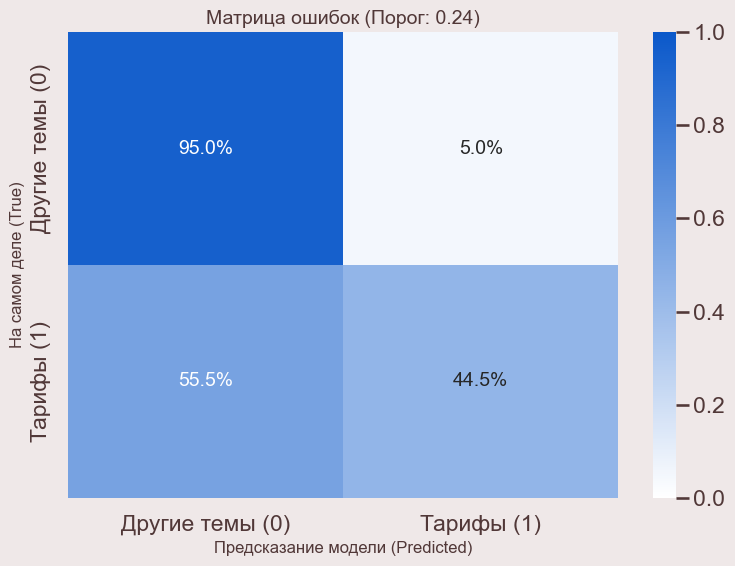

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

threshold = best_threshold if 'best_threshold' in locals() else 0.5

y_pred_probs = logit_model.predict(X.astype(float))
y_pred_classes = (y_pred_probs > threshold).astype(int)

cm_norm = confusion_matrix(y, y_pred_classes, normalize='true')

blue_cmap = LinearSegmentedColormap.from_list('white_blue', ['#FFFFFF', colors['blue']])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap=blue_cmap, vmin=0, vmax=1,
            xticklabels=['Другие темы (0)', 'Тарифы (1)'],
            yticklabels=['Другие темы (0)', 'Тарифы (1)'], annot_kws={"size": 14})
plt.title(f'Матрица ошибок (Порог: {threshold:.2f})', fontsize=14)
plt.ylabel('На самом деле (True)', fontsize=12)
plt.xlabel('Предсказание модели (Predicted)', fontsize=12)
plt.tight_layout()
plt.show()

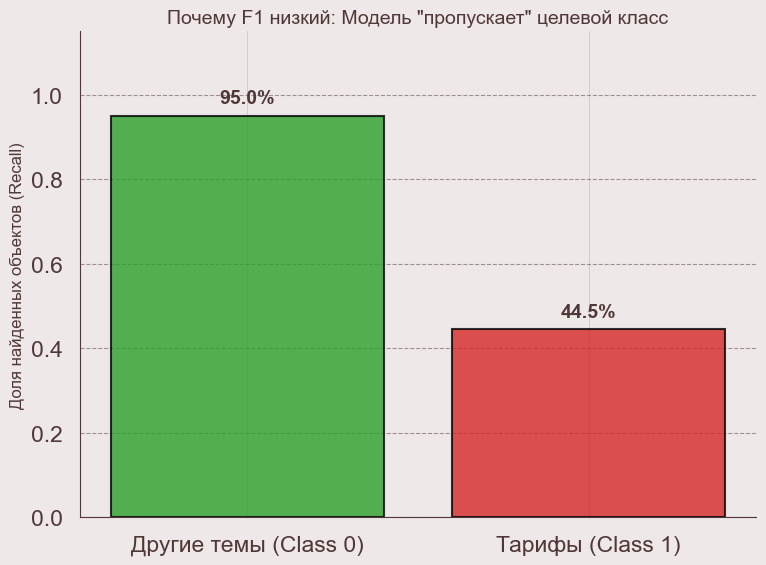

In [ ]:
plt.figure(figsize=(8, 6))
classes = ['Другие темы (Class 0)', 'Тарифы (Class 1)']
recalls = cm_norm.diagonal()

colors = ['#2ca02c' if r > 0.7 else '#d62728' for r in recalls]

bars = plt.bar(classes, recalls, color=colors, alpha=0.8, edgecolor='black')
plt.title('Почему F1 низкий: Модель "пропускает" целевой класс', fontsize=14)
plt.ylabel('Доля найденных объектов (Recall)', fontsize=12)
plt.ylim(0, 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.1%}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()